In [1]:
# Import libraries
import os
import cv2
import IPython
import random
import glob
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Model , load_model
from keras.applications import VGG19
from keras.applications import DenseNet121
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [2]:
# Image config
img_size = 256
num_channels = 3

In [3]:
# This dataset contains 110 brain MR images together with manual FLAIR abnormality segmentation masks. All images are with 3 channels per image. Masks are binary, 1-channel images.
# https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
root_folder = './data/lgg-mri-segmentation/kaggle_3m/'

In [4]:
# loading dataset
masks = glob.glob(f"{root_folder}*/*_mask*")
diagnosis = [np.any(cv2.imread(file)) for file in masks]
images = [file.replace('_mask', '') for file in masks]
print("Images: ", len(images))
print("Masks: ",len(masks))

Images:  3929
Masks:  3929


In [5]:
# Sorting check
idx = random.randint(0, len(images)-1)
print("Path to the Image:", images[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: ./data/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7882_19970125\TCGA_HT_7882_19970125_13.tif 
Path to the Mask: ./data/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7882_19970125\TCGA_HT_7882_19970125_13_mask.tif


In [6]:
missing_masks = 0
for folder in os.listdir(root_folder):
    folderpath = os.path.join(root_folder, folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        if file[:len(file)-4][-1].isnumeric():
            if file[:len(file)-4]+'_mask.tif' not in filelist:
                missing_masks += 1
                print(f"Image without mask: {os.path.join(folderpath, file)}")
print(f"Total number of missing masks: {missing_masks}")

Total number of missing masks: 0


In [7]:
df = pd.DataFrame({"image_path": images, "mask_path": masks, "diagnosis": diagnosis})
df

,image_path,mask_path,diagnosis
0,./data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_...,./data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_...,False
1,./data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_...,./data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_...,True
2,./data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_...,./data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_...,True
3,./data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_...,./data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_...,True
4,./data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_...,./data/lgg-mri-segmentation/kaggle_3m\TCGA_CS_...,True
...,...,...,...
3924,./data/lgg-mri-segmentation/kaggle_3m\TCGA_HT_...,./data/lgg-mri-segmentation/kaggle_3m\TCGA_HT_...,False
3925,./data/lgg-mri-segmentation/kaggle_3m\TCGA_HT_...,./data/lgg-mri-segmentation/kaggle_3m\TCGA_HT_...,False
3926,./data/lgg-mri-segmentation/kaggle_3m\TCGA_HT_...,./data/lgg-mri-segmentation/kaggle_3m\TCGA_HT_...,False
3927,./data/lgg-mri-segmentation/kaggle_3m\TCGA_HT_...,./data/lgg-mri-segmentation/kaggle_3m\TCGA_HT_...,False


diagnosis
False    2556
True     1373
Name: count, dtype: int64


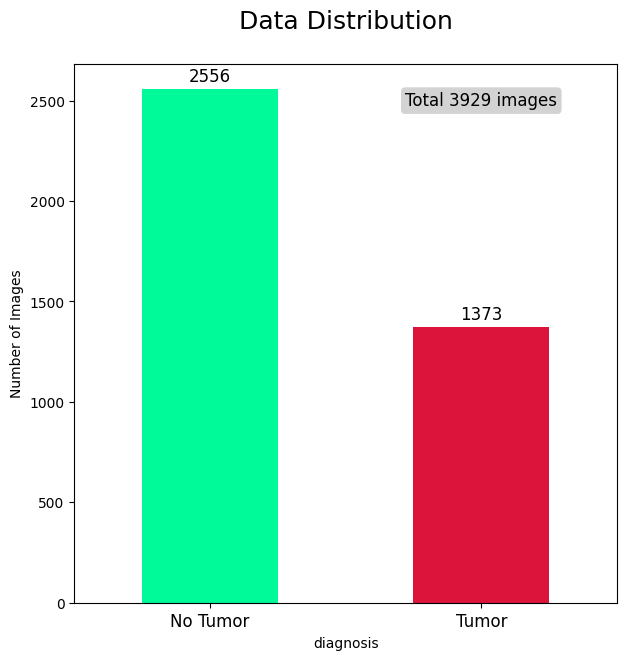

In [8]:
# Plot
print(df['diagnosis'].value_counts())
ax = df['diagnosis'].value_counts().plot(kind='bar',stacked=True,figsize=(7, 7),color=["mediumspringgreen", "crimson"])
ax.set_xticklabels(["No Tumor", "Tumor"], rotation=0, fontsize=12);
ax.set_ylabel('Number of Images', fontsize = 10)
ax.set_title("Data Distribution",fontsize = 18, y=1.05)

for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+20), rotation=0, color="black", ha="center", verticalalignment='bottom', fontsize=12)

ax.text(1, 2500, f"Total {len(df)} images", size=12, color="black", ha="center", va="center", bbox=dict(boxstyle="round", fc=("lightgray"), ec=("white")));

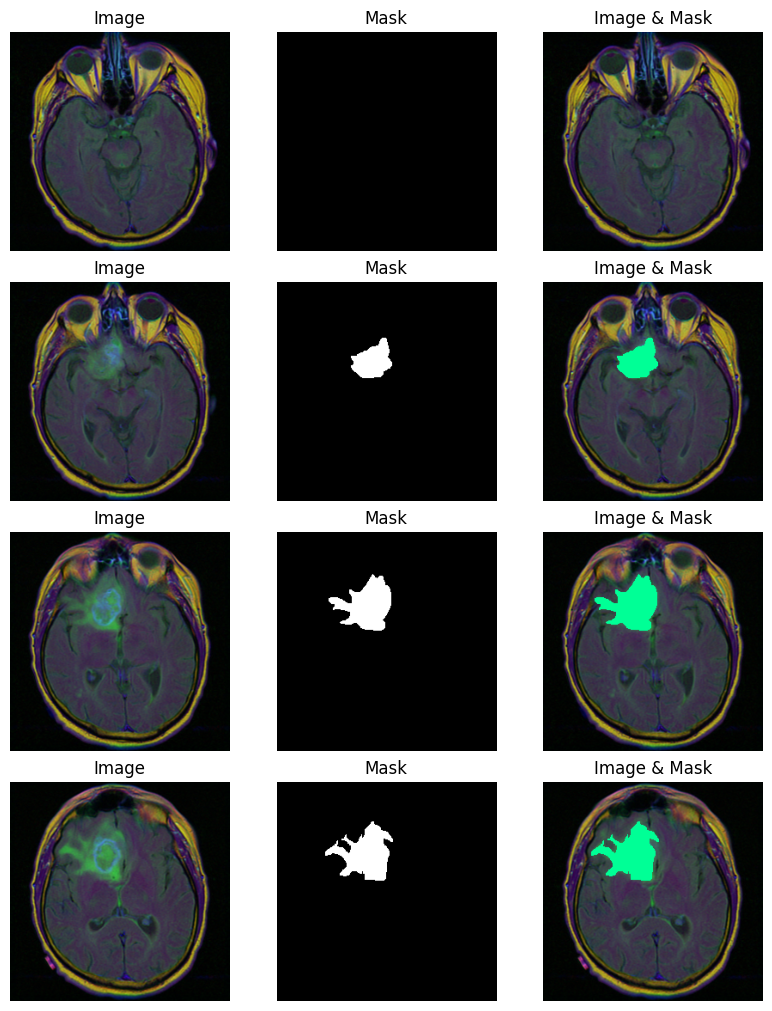

In [9]:
# visualizing data
count = 0
i = 0
fig, axs = plt.subplots(4, 3, figsize=(8, 10), constrained_layout=True)
for sample in df['diagnosis']:
        # read images
    img = io.imread(df.image_path[i])
    axs[count][0].imshow(img, cmap='bone')
    axs[count][0].set_title('Image', fontdict = {'fontsize':12})
    axs[count][0].axis(False)

        # read masks
    msk = io.imread(df.mask_path[i])
    axs[count][1].imshow(msk, cmap='gray')
    axs[count][1].set_title('Mask' , fontdict = {'fontsize':12})
    axs[count][1].axis(False)

    img[msk==255] = (0,255,150)
    axs[count][2].imshow(img)
    axs[count][2].set_title("Image & Mask", fontdict = {'fontsize':12})
    axs[count][2].axis(False)

    count +=1
    i += 1
    if (count==4):
        break

plt.show()

In [10]:
# Convert the data in diagnosis column to string format, to use categorical mode in flow_from_dataframe
df['diagnosis'] = df['diagnosis'].apply(lambda x: str(x))
# spliting data
train_df, test_df = train_test_split(df, stratify=df['diagnosis'], test_size=0.10, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(f"Train : {train_df.shape}")
print(f"Test : {test_df.shape}")

Train : (3536, 3)
Test : (393, 3)


In [11]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(img_size,img_size),
        seed=1):

    image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**aug_dict)
    mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.0
    mask = mask / 255.0
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

In [12]:
train_gen = train_generator(train_df, 16, dict(), target_size=(img_size, img_size))
test_gen = train_generator(test_df, 16, dict(), target_size=(img_size, img_size))

In [13]:
x,y = next(train_gen)
print(x.shape)
print(y.shape)

Found 3536 validated image filenames.
Found 3536 validated image filenames.
(16, 256, 256, 3)
(16, 256, 256, 1)


# Classic U-Net Model

In [14]:
# U-net model
def encoding_block(inputs, filters, max_pooling=True):

    C = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(inputs)
    C = layers.BatchNormalization()(C)
    C = layers.Activation("relu")(C)

    C = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = layers.BatchNormalization()(C)
    C = layers.Activation("relu")(C)

    skip_connection = C

    if max_pooling:
        next_layer = layers.MaxPooling2D(pool_size=(2, 2))(C)
    else:
        next_layer = C

    return next_layer, skip_connection

In [15]:
def decoding_block(inputs, skip_connection_input, filters):
    CT = layers.Conv2DTranspose(filters, 3, strides=(2,2), padding="same", kernel_initializer="he_normal")(inputs)

    residual_connection = layers.concatenate([CT, skip_connection_input], axis=3)

    C = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(residual_connection)
    C = layers.BatchNormalization()(C)
    C = layers.Activation("relu")(C)

    C = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = layers.BatchNormalization()(C)
    C = layers.Activation("relu")(C)

    return C

In [16]:
def unet_model(input_size, filters):
    inputs = layers.Input(input_size)

    # Encoder
    C1, S1 = encoding_block(inputs, filters, max_pooling=True)
    C2, S2 = encoding_block(C1, filters * 2, max_pooling=True)
    C3, S3 = encoding_block(C2, filters * 4, max_pooling=True)
    C4, S4 = encoding_block(C3, filters * 8, max_pooling=True)

    C5, S5 = encoding_block(C4, filters * 16, max_pooling=False)

    # Decoder
    U6 = decoding_block(C5, S4, filters * 8)
    U7 = decoding_block(U6, S3,  filters * 4)
    U8 = decoding_block(U7, S2,  filters = filters * 2)
    U9 = decoding_block(U8, S1,  filters = filters)

    C10 = layers.Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(U9)

    C11 = layers.Conv2D(1, kernel_size = (1,1), activation='sigmoid', padding='same')(C10)

    model = Model(inputs=inputs, outputs=C11)

    return model

In [17]:
unet_model = unet_model((img_size, img_size, num_channels), filters=32)
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 32)         0         ['batch_normalization[0][0

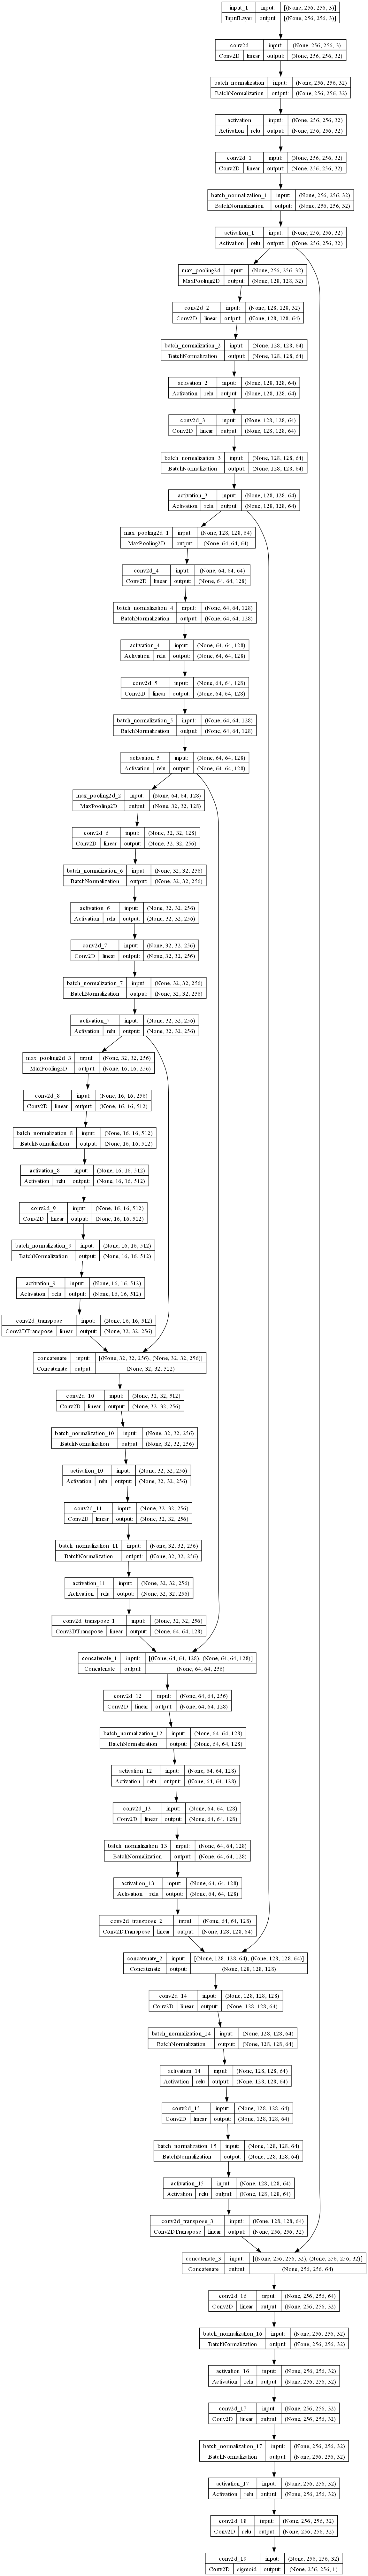

In [18]:
keras.utils.plot_model(
    unet_model,
    to_file='./img/UNet_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [19]:
# compile the model
unet_model.compile(optimizer=Adam(lr = 0.0001), loss='binary_crossentropy', metrics=["accuracy"])

checkpoint_unet = ModelCheckpoint("./CNN_UNet.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='max')
early_stopping_unet = EarlyStopping(monitor='val_loss', patience=20,verbose=1, restore_best_weights=True)
reduce_learningrate_unet = ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=10, verbose=1, min_lr = 2e-6)

callbacks_list_unet = [early_stopping_unet,checkpoint_unet,reduce_learningrate_unet]

In [ ]:
history_unet = unet_model.fit(train_gen, batch_size = 16, steps_per_epoch=len(train_df) / 16, verbose=1, epochs= 30, validation_data=test_gen, validation_steps=len(test_df) / 16, callbacks = callbacks_list_unet)

Epoch 1/30
221/221 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9927Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_loss improved from -inf to 0.02782, saving model to ./CNN_UNet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


221/221 [==============================] - 98s 444ms/step - loss: 0.0196 - accuracy: 0.9927 - val_loss: 0.0278 - val_accuracy: 0.9926 - lr: 0.0010
Epoch 2/30
221/221 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9944
Epoch 2: val_loss did not improve from 0.02782
221/221 [==============================] - 92s 415ms/step - loss: 0.0178 - accuracy: 0.9944 - val_loss: 0.0189 - val_accuracy: 0.9943 - lr: 0.0010
Epoch 3/30
221/221 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9949
Epoch 3: val_loss did not improve from 0.02782
221/221 [==============================] - 90s 405ms/step - loss: 0.0169 - accuracy: 0.9949 - val_loss: 0.0222 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 4/30
221/221 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9951
Epoch 4: val_loss did not improve from 0.02782
221/221 [==============================] - 92s 415ms/step - loss: 0.0158 - accuracy: 0.9951 - val_loss: 0.0152 - val_accuracy: 0.9

In [ ]:
df_result_unet = pd.DataFrame(history_unet.history)
df_result_unet

,loss,accuracy,val_loss,val_accuracy,lr
0,0.019563,0.992685,0.027820,0.992642,0.001
1,0.017844,0.994435,0.018890,0.994254,0.001
2,0.016875,0.994890,0.022199,0.993630,0.001
3,0.015762,0.995109,0.015220,0.995589,0.001
4,0.014523,0.995313,0.020136,0.995122,0.001
5,0.012131,0.995869,0.012402,0.995371,0.001
6,0.010713,0.996155,0.012948,0.995514,0.001
7,0.010188,0.996306,0.013010,0.995520,0.001
8,0.009541,0.996558,0.033154,0.986840,0.001
9,0.009020,0.996707,0.008811,0.996726,0.001


In [ ]:
# evalute model
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

loss_unet,acc_unet = unet_model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("accuracy:", acc_unet)

131/131 [==============================] - 16s 119ms/step - loss: 0.0059 - accuracy: 0.9980
accuracy: 0.9979679584503174


<Axes: >

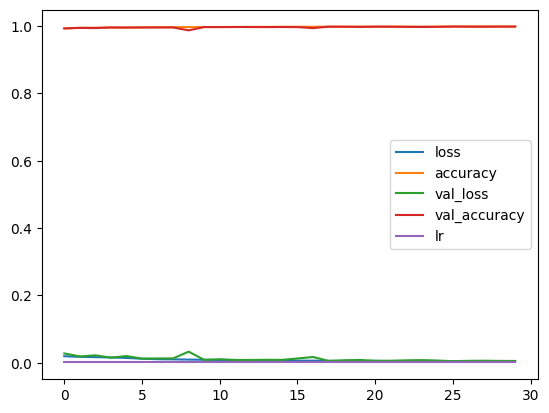

In [ ]:
pd.DataFrame(history_unet.history).plot()

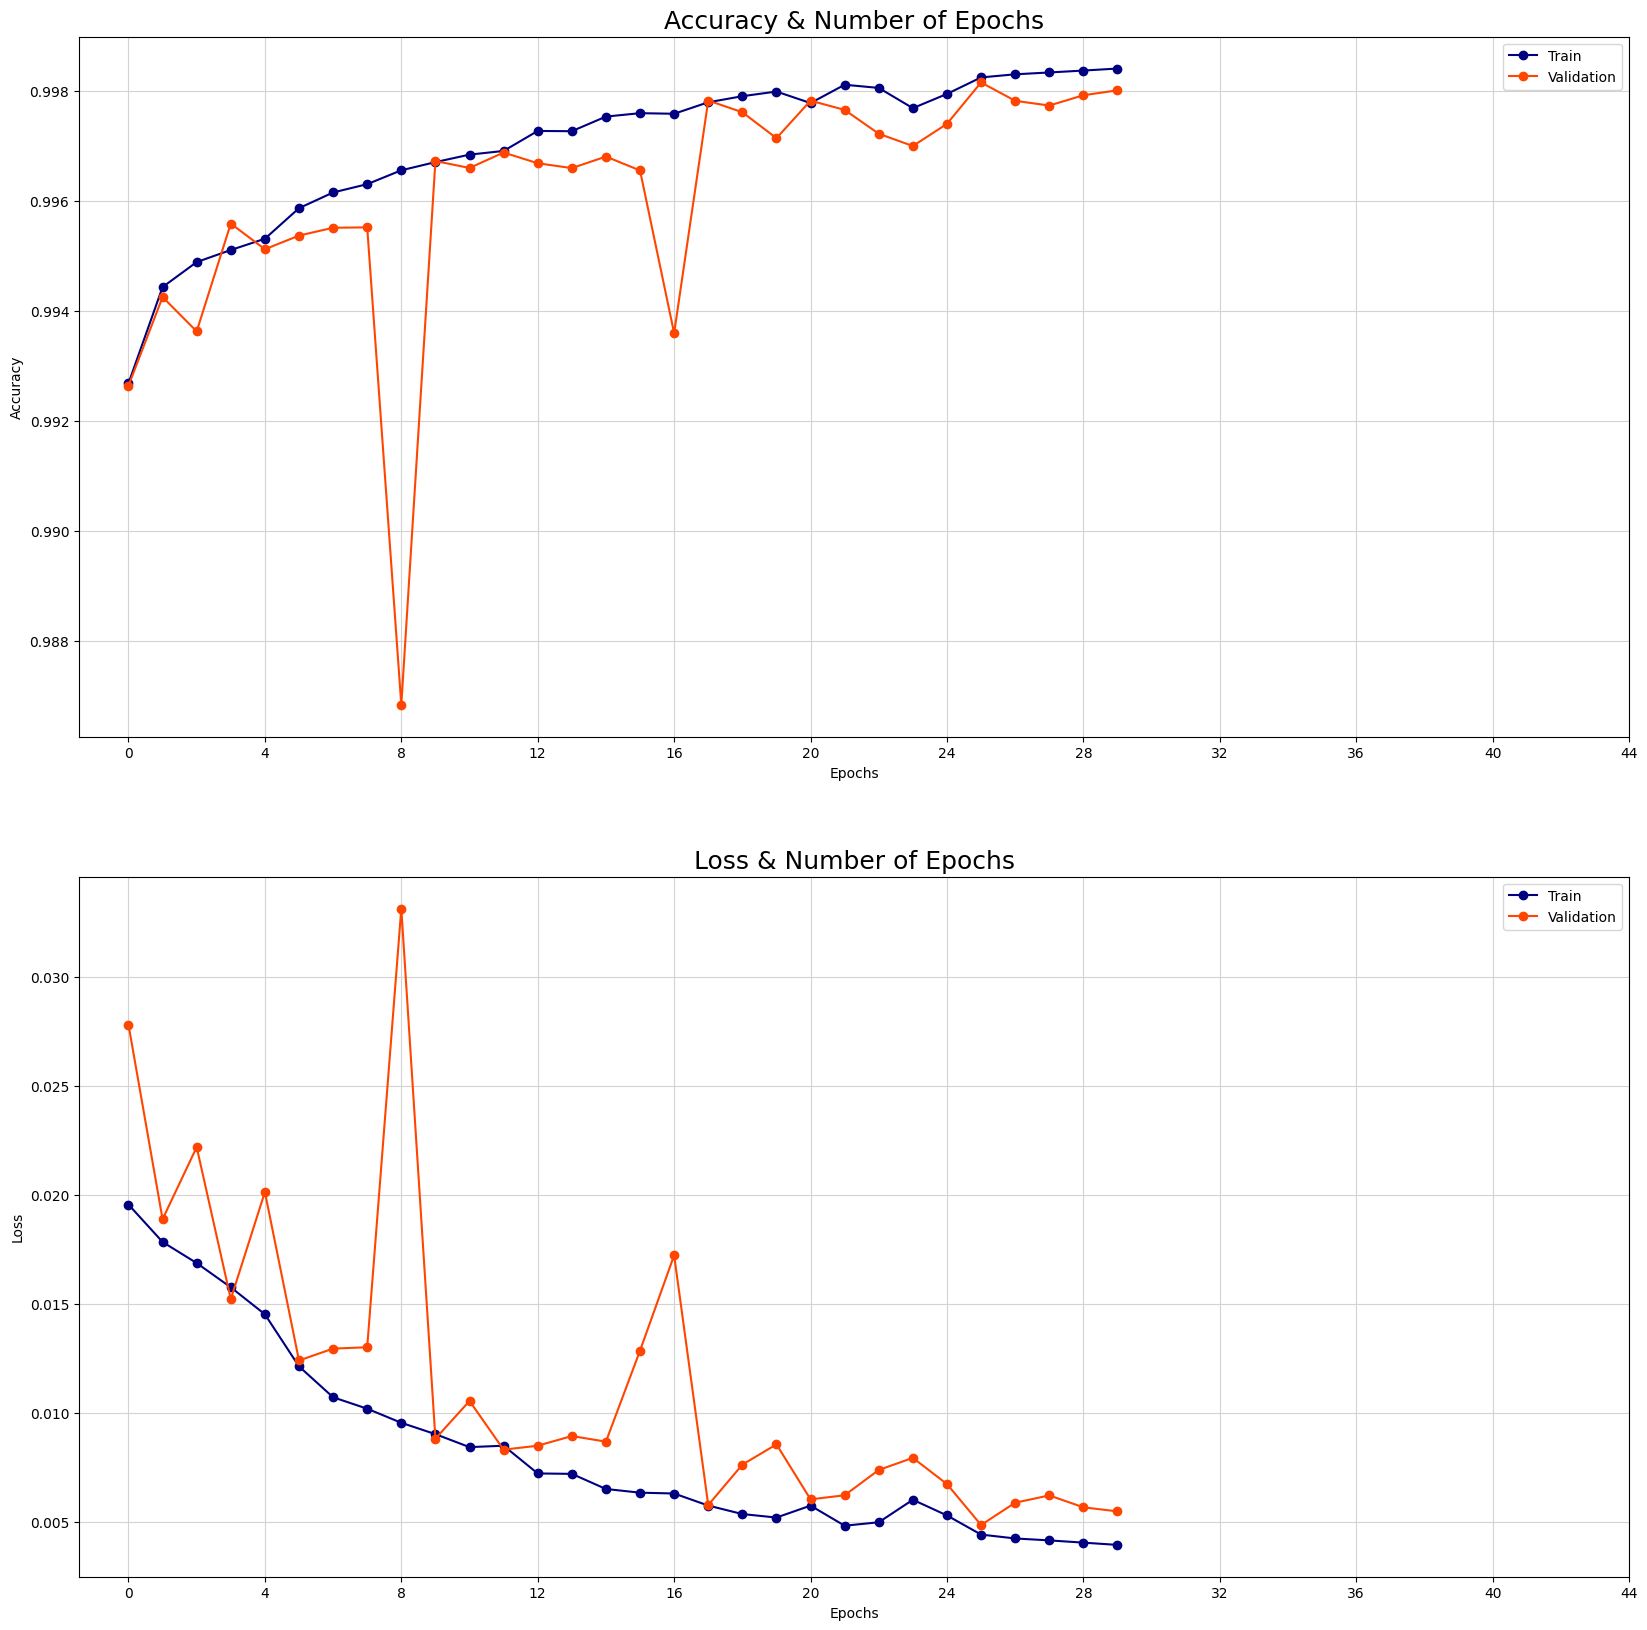

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax = ax.ravel()
metrics_unet = ['Accuracy', 'Loss']

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_unet.history[met], 'o-',color= 'navy')
    ax[i].plot(history_unet.history['val_' + met], 'o-',color= 'orangered')
    ax[i].set_title('{} & Number of Epochs'.format(metrics_unet[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics_unet[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")

In [ ]:
y_pred_unet=unet_model.predict(test_gen, steps= test_steps)

131/131 [==============================] - 15s 109ms/step


In [ ]:
unet_model.save("./CNN_Unet.h5")

In [20]:
unet_model = load_model('./models/CNN_Unet.h5', compile=True, safe_mode=True)

In [23]:
# evalute model
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

loss_unet,acc_unet= unet_model.evaluate(test_gen, steps= test_steps, verbose=1)
print("accuracy:", acc_unet)

Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 [==============================] - 293s 2s/step - loss: 0.0042 - accuracy: 0.9984
accuracy: 0.9983938336372375


1/1 [==============================] - 0s 155ms/step


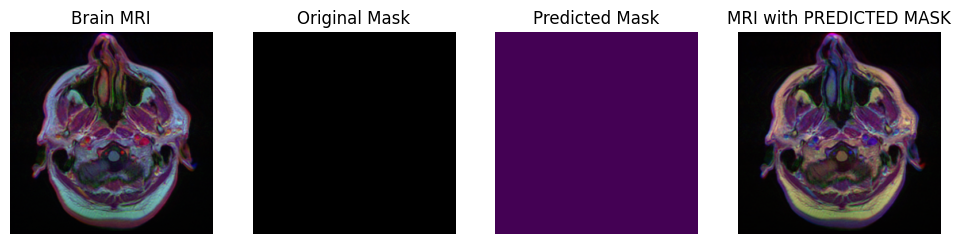

1/1 [==============================] - 0s 134ms/step


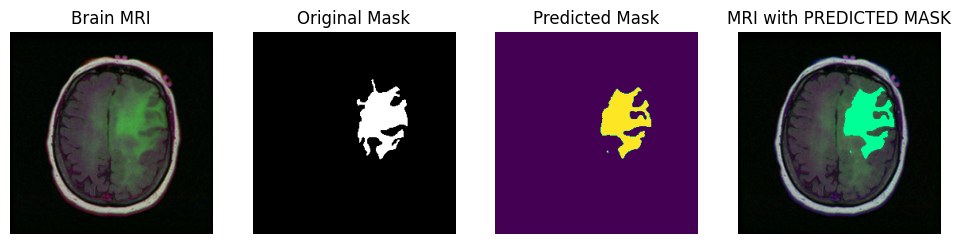

1/1 [==============================] - 0s 133ms/step


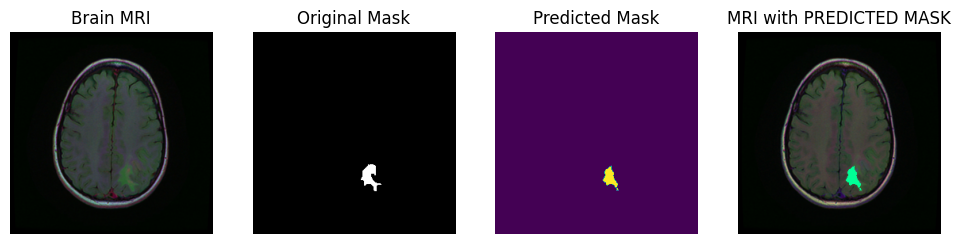

1/1 [==============================] - 0s 169ms/step


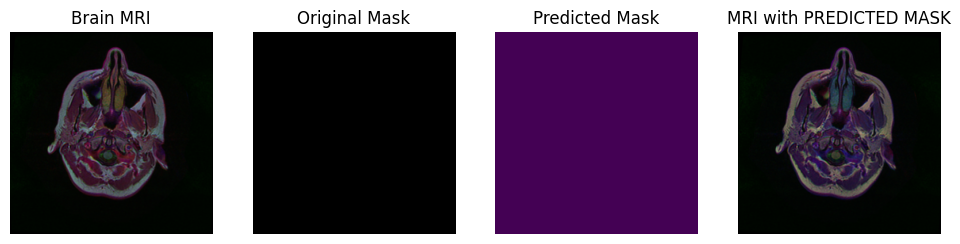

1/1 [==============================] - 0s 138ms/step


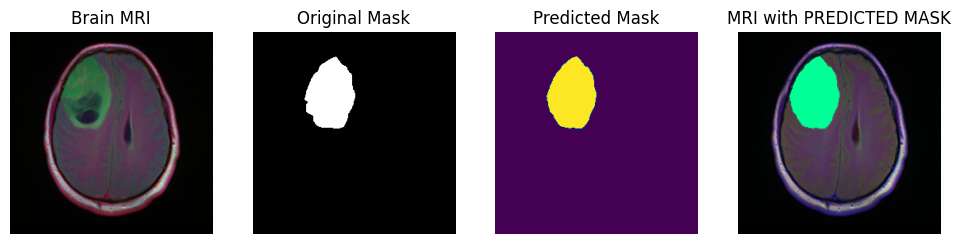

1/1 [==============================] - 0s 173ms/step


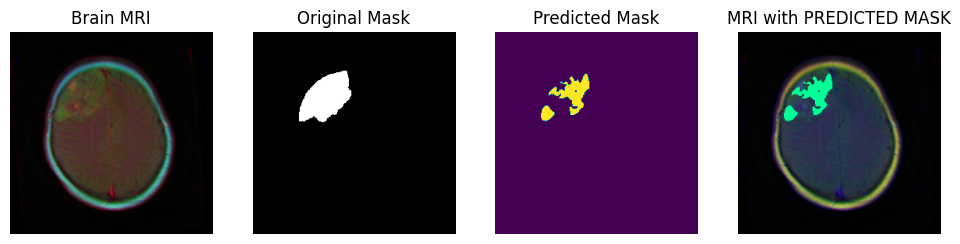

In [31]:
#visualizing prediction
for _ in range(6):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['image_path'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = unet_model.predict(img)

    plt.figure(figsize=(12, 12))

    plt.subplot(1, 4, 1)
    plt.imshow(np.array(img).squeeze())
    plt.axis('off')
    plt.title('Brain MRI')

    plt.subplot(1, 4, 2)
    mask = cv2.imread(test_df['mask_path'].iloc[index])
    plt.imshow(np.array(mask).squeeze())
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 4, 3)
    pred = np.array(predicted_img).squeeze().round()
    plt.imshow(pred)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    img_ = cv2.imread(test_df['image_path'].iloc[index])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[pred==1] = (0,255,150)
    plt.imshow(img_)
    plt.title('MRI with PREDICTED MASK')
    plt.axis('off')

    plt.show()